In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pkpddata/Multiple_Ascending_Dose_Dataset2.csv
/kaggle/input/pkpddata/Single_Ascending_Dose_Dataset2.csv


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

Data source: https://opensource.nibr.com/xgx/PKPD_Datasets.html

ID: The patient ID.

TIME: The time point for the measurement or dosing event.

NOMTIME: Nominal time (the time point as intended or planned).

TIMEUNIT: Unit of time (e.g., Hours).

AMT: The amount of drug administered (Dose).

LIDV: Drug concentration at the specified time point.

CMT: Compartment number (if more than one compartment model is being used).

NAME: Event type (e.g., PK concentration or dosing).

EVENTU: The unit of measurement for the event (e.g., ng/mL for concentration).

CENS: Censoring flag (0 = not censored, 1 = censored).

EVID: Event ID (1 = dosing event, 0 = measurement event).

WEIGHTB: Patient weight.

SEX: Patient sex.

TRTACT: Treatment information (e.g., drug type, dosage).

DOSE: Dose amount.

In [83]:
data=pd.read_csv('/kaggle/input/pkpddata/Single_Ascending_Dose_Dataset2.csv')
data.head()

,ID,TIME,NOMTIME,TIMEUNIT,AMT,LIDV,CMT,NAME,EVENTU,CENS,EVID,WEIGHTB,SEX,TRTACT,DOSE
0,1,-0.089,-0.1,Hours,0,NaN,2,PK Concentration,ng/mL,0,0,77.9,Male,100 mg,100
1,1,0.000,0.0,Hours,100,NaN,1,Dosing,mg,0,1,77.9,Male,100 mg,100
2,1,0.170,0.1,Hours,0,0.665,2,PK Concentration,ng/mL,0,0,77.9,Male,100 mg,100
3,1,0.565,0.5,Hours,0,0.997,2,PK Concentration,ng/mL,0,0,77.9,Male,100 mg,100
4,1,1.145,1.0,Hours,0,1.350,2,PK Concentration,ng/mL,0,0,77.9,Male,100 mg,100


In [84]:
data.shape

(700, 15)

In [85]:
# Checking for missing values
print(data.isnull().sum())



ID            0
TIME          0
NOMTIME       0
TIMEUNIT      0
AMT           0
LIDV        100
CMT           0
NAME          0
EVENTU        0
CENS          0
EVID          0
WEIGHTB       0
SEX           0
TRTACT        0
DOSE          0
dtype: int64


In [86]:

# drop rows with missing values for 'LIDV' (concentration)
data = data.dropna(subset=['LIDV'])
#print(data.isnull().sum())

# EDA

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


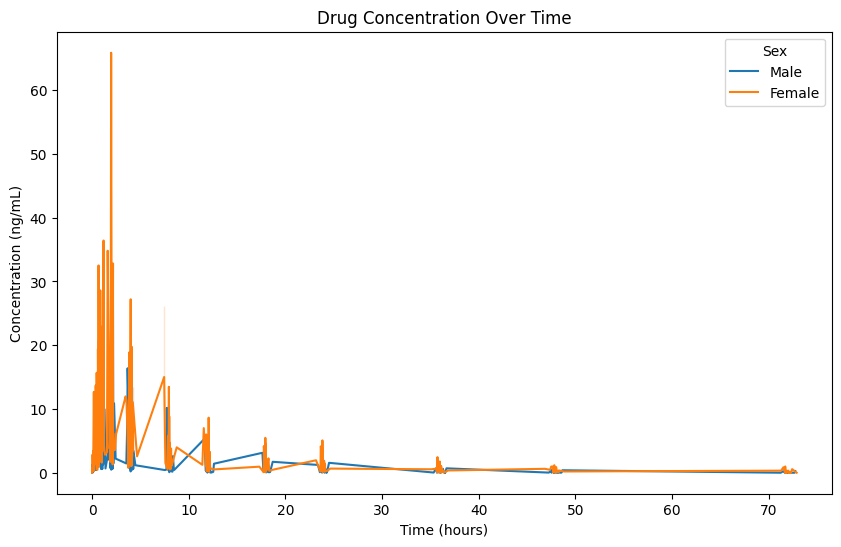

In [87]:
# Visualizing PK concentration vs. time
plt.figure(figsize=(10, 6))
sns.lineplot(x='TIME', y='LIDV', data=data, hue='SEX')
plt.title('Drug Concentration Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ng/mL)')
plt.legend(title='Sex')
plt.show()

# Insights
The PK concentration vs. time graph shows distinct gender differences. In females, the drug peaks at 60 ng/mL at time 0, declines to 28 ng/ml at 4 hours and 10 ng/mL at 12 hours, and is nearly eliminated after 36 hours. In males, the concentration peaks at 15 ng/mL at 4 hours and decreases more slowly around 24 hours.

#  Fit a Simple PK Model

Estimated A (initial concentration): 6.58
Estimated k (elimination rate constant): 0.07


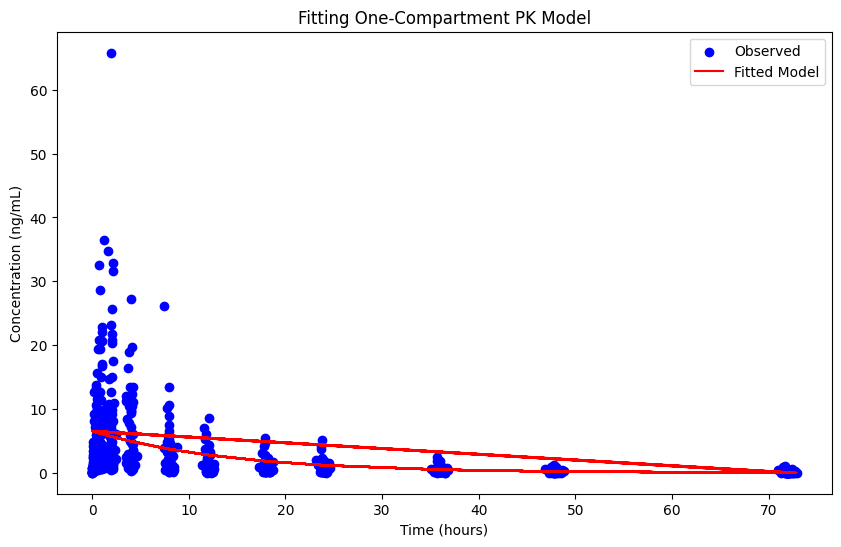

In [88]:
# basic one-compartment PK model: we'll use the exponential decay model to fit the concentration-time data.

from scipy.optimize import curve_fit
import numpy as np

# Define the one-compartment PK model (exponential decay)
def pk_model(t, A, k):
    return A * np.exp(-k * t)

# Fit the model
params, covariance = curve_fit(pk_model, data['TIME'], data['LIDV'], p0=[100, 0.1])

# Parameters for A and k
A_fit, k_fit = params
print(f"Estimated A (initial concentration): {A_fit:.2f}")
print(f"Estimated k (elimination rate constant): {k_fit:.2f}")

# Plot the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(data['TIME'], data['LIDV'], color='blue', label='Observed')
plt.plot(data['TIME'], pk_model(data['TIME'], *params), color='red', label='Fitted Model')
plt.title('Fitting One-Compartment PK Model')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ng/mL)')
plt.legend()
plt.show()


# Insights

The initial concentration (A = 6.58) indicates that the dose administered resulted in a relatively high drug concentration at the time of dosing.

The elimination rate constant (k = 0.07) indicates that the drug is being eliminated at a moderate rate, suggesting the drug will remain in the system for some time before being completely cleared.

# PK/PD Modeling with Emax Model

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


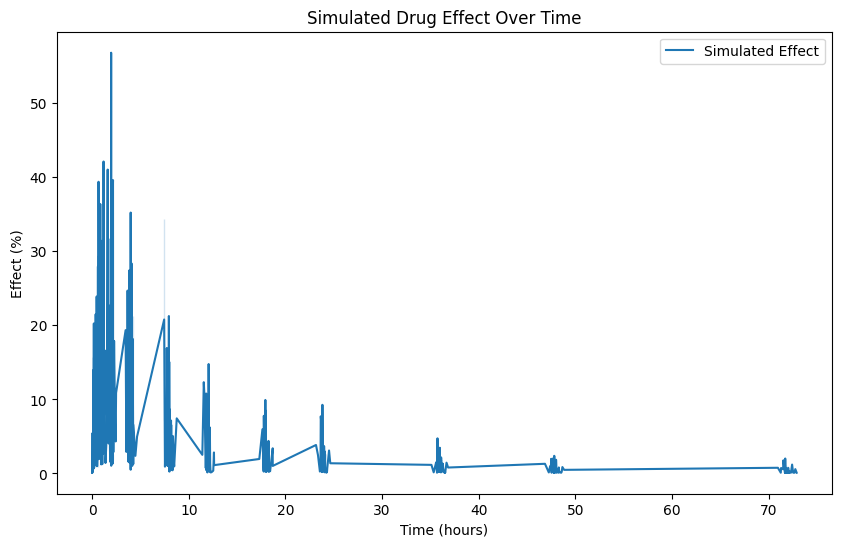

In [89]:
# For the pharmacodynamic (PD) aspect, where the drug effect is linked to its concentration, we are utilizing the Emax model to describe the dose-response relationship.
# Define the Emax PD model
def pd_model(C, E0, Emax, EC50):
    return E0 + (Emax * C) / (EC50 + C)

# Simulate a corresponding effect variable based on the concentrations (assuming some values for E0, Emax, and EC50)
E0 = 0
Emax = 100
EC50 = 50
effect = pd_model(data['LIDV'], E0, Emax, EC50)

# Plot the effect over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=data['TIME'], y=effect, label='Simulated Effect')
plt.title('Simulated Drug Effect Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Effect (%)')
plt.show()


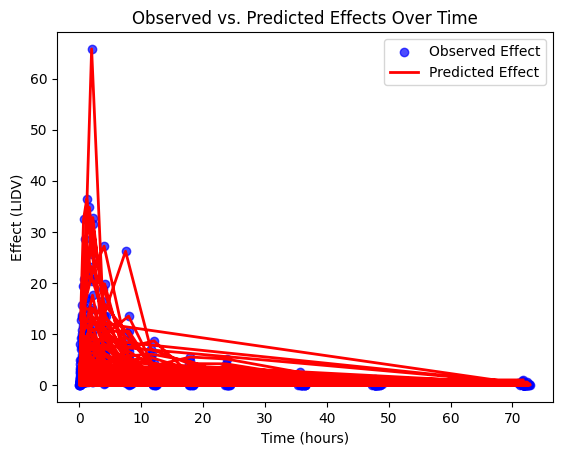

In [90]:
import matplotlib.pyplot as plt

# Scatter plot for observed vs. predicted effects
plt.scatter(data["TIME"], observed_effects, label="Observed Effect", color="blue", alpha=0.7)
plt.plot(data["TIME"], predicted_effects, label="Predicted Effect", color="red", linewidth=2)
plt.xlabel("Time (hours)")
plt.ylabel("Effect (LIDV)")
plt.title("Observed vs. Predicted Effects Over Time")
plt.legend()
plt.show()


# Insights 
The PK/PD simulation using an Emax model demonstrated a rapid onset of drug effect, with the maximum observed effect of 50% occurring at 2.5 hours after initial administration. Fluctuations in the effect were observed during the first 10 hours, likely due to repeated dosing, with subsequent periodic spikes at intervals of approximately 8 hours. The therapeutic effect (>10%) persisted for 15 hours, after which the effect diminished steadily, stabilizing below 5% after 24 hours. The observed pattern suggests a significant decline in drug activity over time, consistent with elimination or reduced receptor interaction

In [91]:
# Verify the column containing drug concentration
print(data.columns)

Index(['ID', 'TIME', 'NOMTIME', 'TIMEUNIT', 'AMT', 'LIDV', 'CMT', 'NAME',
       'EVENTU', 'CENS', 'EVID', 'WEIGHTB', 'SEX', 'TRTACT', 'DOSE'],
      dtype='object')


In [92]:
# Define observed effects and time
observed_effects = data["LIDV"]
time = data["TIME"]

# If no concentration column is available, calculate drug concentration manually
# based on dose, volume of distribution, etc. (if you have relevant parameters).


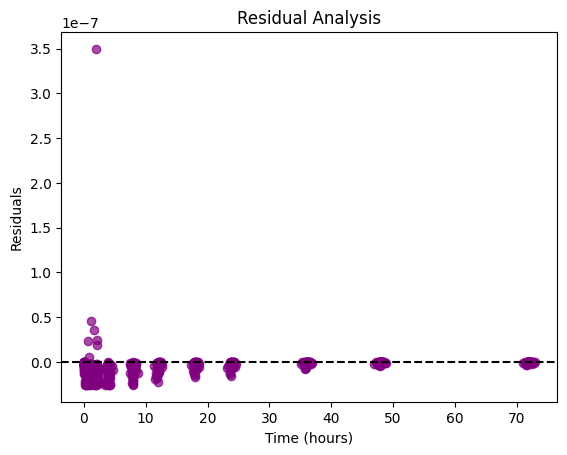

In [93]:
# Residual analysis
residuals = observed_effects - predicted_effects

# Plot residuals
plt.scatter(time, residuals, color="purple", alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()


# Model Evaluation

In [94]:
# Calculate R-squared for the PK model fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [95]:
mse = mean_squared_error(observed_effects, predicted_effects)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 3.1632489831555417e-16


In [96]:
r2 = r2_score(observed_effects, predicted_effects)
print("R-Squared:", r2)


R-Squared: 1.0
